In [2]:
!nvidia-smi

Sun Jan 19 15:22:24 2025       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.104.05             Driver Version: 535.104.05   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  Tesla T4                       Off | 00000000:00:04.0 Off |                    0 |
| N/A   42C    P8              12W /  70W |      0MiB / 15360MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [3]:
## DATA
import sklearn
from sklearn.datasets import make_circles

n_samples=1000
x,y=make_circles(n_samples,noise=0.03,random_state=35)

In [4]:
print(x)

[[-0.4670712  -0.70384742]
 [ 0.04924033  0.80945133]
 [-0.14835946  0.84169802]
 ...
 [ 0.62095261 -0.45144505]
 [-0.97069044 -0.25982821]
 [-0.70537406  0.40849922]]


In [5]:
import pandas as pd
circles=pd.DataFrame({"X1":x[:,0],"X2":x[:,1],"label":y[:]})
circles.head()

,X1,X2,label
0,-0.467071,-0.703847,1
1,0.049240,0.809451,1
2,-0.148359,0.841698,1
3,0.567739,-0.495415,1
4,-0.439440,-0.702983,1


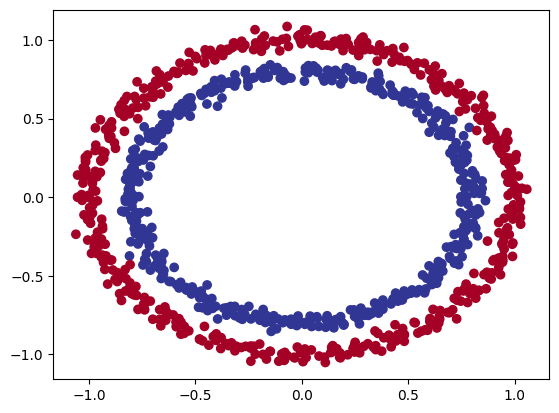

In [6]:
import matplotlib.pyplot as plt
plt.scatter(x=x[:,0],
            y=x[:,1],
            c=y,
            cmap=plt.cm.RdYlBu)

In [7]:
## CHECK INPUT AND OUPUT SHAPES
x.shape,y.shape

((1000, 2), (1000,))

In [8]:
import torch
torch.__version__

'2.5.1+cu121'

In [9]:
X=torch.from_numpy(x).type(torch.float)
Y=torch.from_numpy(y).type(torch.float)

In [10]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test=train_test_split(X,Y,random_state=42,test_size=0.2)

In [11]:
#BUILDING A MODEL
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

In [12]:
import torch
from torch import nn

class CircleModelV0(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=5)
    self.layers_2=nn.Linear(in_features=5,out_features=1)

  def forward(self, x):
        return self.layers_2(self.layer_1(x))

model_0=CircleModelV0().to(device)
model_0


CircleModelV0(
  (layer_1): Linear(in_features=2, out_features=5, bias=True)
  (layers_2): Linear(in_features=5, out_features=1, bias=True)
)

In [13]:
model=nn.Sequential(
    nn.Linear(in_features=2,out_features=5),
    nn.Linear(in_features=5,out_features=1)
).to(device)
model

Sequential(
  (0): Linear(in_features=2, out_features=5, bias=True)
  (1): Linear(in_features=5, out_features=1, bias=True)
)

In [14]:
model.state_dict()

OrderedDict([('0.weight',
              tensor([[-0.0537, -0.4454],
                      [ 0.4460, -0.6875],
                      [-0.3319, -0.6216],
                      [-0.6895, -0.1227],
                      [ 0.3940, -0.6405]], device='cuda:0')),
             ('0.bias',
              tensor([-0.3025, -0.2205,  0.1807,  0.2075,  0.6898], device='cuda:0')),
             ('1.weight',
              tensor([[ 0.1239, -0.1356, -0.3298,  0.3373, -0.1941]], device='cuda:0')),
             ('1.bias', tensor([-0.1065], device='cuda:0'))])

In [15]:
untrained_pred=model_0(X_test.to(device))
print(f"Length of predictions: {len(untrained_pred)}")
print(untrained_pred[:10])


Length of predictions: 200
tensor([[-0.1488],
        [-0.1386],
        [-0.1451],
        [-0.1390],
        [-0.1341],
        [-0.1843],
        [-0.1722],
        [-0.1897],
        [-0.1326],
        [-0.1527]], device='cuda:0', grad_fn=<SliceBackward0>)


In [16]:
#SETTING UP THE TRAINING LOOP

In [17]:
loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model.parameters(),
                          lr=0.1)

In [18]:
def accuracy_fn(y_true,y_pred):
  correct=torch.eq(y_true,y_pred).sum().item()
  acc=(correct/len(y_pred))*100
  return acc

TRAINING OUR MODEL

forward pass

calculate the loss

optimizer zero grad

loss backward(backpropagation)

optimizer step(gradient descent)

In [19]:
model.eval()
with torch.inference_mode():
  y_logits=model(X_test.to(device))[:5]
y_logits


tensor([[-0.1692],
        [-0.0203],
        [-0.1232],
        [-0.0196],
        [ 0.0160]], device='cuda:0')

In [20]:
y_pred_prob=torch.sigmoid(y_logits)

y_pred_prob

y_pred=torch.round(y_pred_prob)

y_pred_labels=torch.round(torch.sigmoid(model(X_test.to(device))[:5]))

print(torch.eq(y_pred.squeeze(),y_pred_labels.squeeze()))

y_pred.squeeze()

tensor([True, True, True, True, True], device='cuda:0')


tensor([0., 0., 0., 0., 1.], device='cuda:0')

In [22]:
#building a training and test loop
torch.manual_seed(42)

epochs=100
X_train,X_test=X_train.to(device),X_test.to(device)
y_train,y_test=y_train.to(device),y_test.to(device)

for epoch in range(epochs):
  ##TRAINING
  model.train()
  # FORWARD PASS
  y_logits=model(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  #CALCULATE THE LOSS AND ACCURACY
  loss=loss_fn(y_logits,
               y_train)

  acc=accuracy_fn(y_true=y_train,
                  y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model.eval()
  with torch.inference_mode():
    test_logits=model_0(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))

    test_loss=loss_fn(test_logits,
                      y_test)
    test_acc=accuracy_fn(y_pred=test_pred,
                         y_true=y_test)

    if epoch%10==0:
      print(f"Epoch: {epoch}| Loss: {loss} | Acc: {acc} | Test_loss:{test_loss} | test_acc: {test_acc}")

Epoch: 0| Loss: 0.6933643817901611 | Acc: 50.74999999999999 | Test_loss:0.6940793991088867 | test_acc: 51.5
Epoch: 10| Loss: 0.6932674050331116 | Acc: 50.875 | Test_loss:0.6940793991088867 | test_acc: 51.5
Epoch: 20| Loss: 0.6931926012039185 | Acc: 51.125 | Test_loss:0.6940793991088867 | test_acc: 51.5
Epoch: 30| Loss: 0.6931345462799072 | Acc: 51.0 | Test_loss:0.6940793991088867 | test_acc: 51.5
Epoch: 40| Loss: 0.6930891871452332 | Acc: 51.5 | Test_loss:0.6940793991088867 | test_acc: 51.5
Epoch: 50| Loss: 0.6930536031723022 | Acc: 51.625 | Test_loss:0.6940793991088867 | test_acc: 51.5
Epoch: 60| Loss: 0.6930255889892578 | Acc: 51.37500000000001 | Test_loss:0.6940793991088867 | test_acc: 51.5
Epoch: 70| Loss: 0.6930033564567566 | Acc: 51.37500000000001 | Test_loss:0.6940793991088867 | test_acc: 51.5
Epoch: 80| Loss: 0.6929858326911926 | Acc: 51.125 | Test_loss:0.6940793991088867 | test_acc: 51.5
Epoch: 90| Loss: 0.6929717659950256 | Acc: 51.5 | Test_loss:0.6940793991088867 | test_acc:

CREATING A LARGER MODEL

In [25]:
class CircleModelV1(nn.Module):
  def __init__(self):
    super().__init__()
    self.layer_1=nn.Linear(in_features=2,out_features=10)
    self.layer_2=nn.Linear(in_features=10,out_features=10)
    self.layer_3=nn.Linear(in_features=10,out_features=10)
    self.layer_4=nn.Linear(in_features=10,out_features=1)

  def forward(self,x):
    z=self.layer_1(x)
    z=self.layer_2(z)
    z=self.layer_3(z)
    z=self.layer_4(z)
    return z
model_1=CircleModelV1().to(device)
model_1




CircleModelV1(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
)

In [26]:
loss_fn=nn.BCEWithLogitsLoss()

optimizer=torch.optim.SGD(params=model_1.parameters(),
                          lr=0.1)

In [31]:
torch.manual_seed(77)
epochs=1000

X_train,X_test=X_train.to(device),X_test.to(device)
y_train,y_test=y_train.to(device),y_test.to(device)


for epoch in range(epochs):
  model_1.train()

  y_logits=model_1(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,
                  y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_1.eval()
  with torch.inference_mode():
    test_logits=model_1(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_pred)

  if epoch%100==0:
    print(f"EPOCH: {epoch} | LOSS:{loss} | ACC:{acc} | TESTLOSS: {test_loss} | TESTACC:{test_acc}")


EPOCH: 0 | LOSS:0.7094042897224426 | ACC:50.375 | TESTLOSS: 0.7128247022628784 | TESTACC:48.5
EPOCH: 100 | LOSS:0.6932899355888367 | ACC:50.875 | TESTLOSS: 0.6934703588485718 | TESTACC:52.5
EPOCH: 200 | LOSS:0.6930776834487915 | ACC:52.87500000000001 | TESTLOSS: 0.6939146518707275 | TESTACC:48.5
EPOCH: 300 | LOSS:0.6929875612258911 | ACC:53.25 | TESTLOSS: 0.6942917704582214 | TESTACC:47.5
EPOCH: 400 | LOSS:0.6929471492767334 | ACC:52.87500000000001 | TESTLOSS: 0.6945743560791016 | TESTACC:46.0
EPOCH: 500 | LOSS:0.6929289102554321 | ACC:52.87500000000001 | TESTLOSS: 0.6947790384292603 | TESTACC:44.0
EPOCH: 600 | LOSS:0.6929206848144531 | ACC:52.625 | TESTLOSS: 0.6949234008789062 | TESTACC:44.5
EPOCH: 700 | LOSS:0.692916989326477 | ACC:52.625 | TESTLOSS: 0.695023238658905 | TESTACC:44.5
EPOCH: 800 | LOSS:0.6929153800010681 | ACC:52.125 | TESTLOSS: 0.6950913667678833 | TESTACC:44.5
EPOCH: 900 | LOSS:0.6929146647453308 | ACC:52.37500000000001 | TESTLOSS: 0.6951374411582947 | TESTACC:45.5


CREATING AN ACTUAL NON LINEAR MODEL

In [41]:
import torch
import torch.nn as nn

class CircleModelV2(nn.Module):
    def __init__(self):
        super().__init__()
        self.layer_1 = nn.Linear(in_features=2, out_features=10)
        self.layer_2 = nn.Linear(in_features=10, out_features=10)
        self.layer_3 = nn.Linear(in_features=10, out_features=10)
        self.layer_4 = nn.Linear(in_features=10, out_features=1)
        self.relu = nn.ReLU()

    def forward(self, x):
        x = self.relu(self.layer_1(x))
        x = self.relu(self.layer_2(x))
        x = self.relu(self.layer_3(x))
        x = self.layer_4(x)
        return x

# Move the model to the desired device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model_3 = CircleModelV2().to(device)
print(model_3)

CircleModelV2(
  (layer_1): Linear(in_features=2, out_features=10, bias=True)
  (layer_2): Linear(in_features=10, out_features=10, bias=True)
  (layer_3): Linear(in_features=10, out_features=10, bias=True)
  (layer_4): Linear(in_features=10, out_features=1, bias=True)
  (relu): ReLU()
)


In [42]:
loss_fn=nn.BCEWithLogitsLoss()
optimizer=torch.optim.SGD(model_3.parameters(),lr=0.1)

In [43]:
torch.manual_seed(77)
epochs=1000

X_train,X_test=X_train.to(device),X_test.to(device)
y_train,y_test=y_train.to(device),y_test.to(device)


for epoch in range(epochs):
  model_3.train()

  y_logits=model_3(X_train).squeeze()
  y_pred=torch.round(torch.sigmoid(y_logits))

  loss=loss_fn(y_logits,y_train)
  acc=accuracy_fn(y_true=y_train,
                  y_pred=y_pred)

  optimizer.zero_grad()

  loss.backward()

  optimizer.step()

  model_3.eval()
  with torch.inference_mode():
    test_logits=model_3(X_test).squeeze()
    test_pred=torch.round(torch.sigmoid(test_logits))
    test_loss=loss_fn(test_logits,y_test)
    test_acc=accuracy_fn(y_true=y_test,
                         y_pred=test_pred)

  if epoch%100==0:
    print(f"EPOCH: {epoch} | LOSS:{loss} | ACC:{acc} | TESTLOSS: {test_loss} | TESTACC:{test_acc}")


EPOCH: 0 | LOSS:0.7106653451919556 | ACC:49.625 | TESTLOSS: 0.7031319737434387 | TESTACC:51.5
EPOCH: 100 | LOSS:0.6919329166412354 | ACC:57.875 | TESTLOSS: 0.6928150653839111 | TESTACC:54.50000000000001
EPOCH: 200 | LOSS:0.6910194754600525 | ACC:68.375 | TESTLOSS: 0.6922436356544495 | TESTACC:68.0
EPOCH: 300 | LOSS:0.6899171471595764 | ACC:67.0 | TESTLOSS: 0.69147789478302 | TESTACC:61.5
EPOCH: 400 | LOSS:0.6883057951927185 | ACC:62.25000000000001 | TESTLOSS: 0.690417468547821 | TESTACC:57.99999999999999
EPOCH: 500 | LOSS:0.6857869029045105 | ACC:63.375 | TESTLOSS: 0.6888105869293213 | TESTACC:59.5
EPOCH: 600 | LOSS:0.6819475889205933 | ACC:66.625 | TESTLOSS: 0.6858994960784912 | TESTACC:65.0
EPOCH: 700 | LOSS:0.6753156185150146 | ACC:66.25 | TESTLOSS: 0.6802474856376648 | TESTACC:64.0
EPOCH: 800 | LOSS:0.6615815758705139 | ACC:61.0 | TESTLOSS: 0.6676128506660461 | TESTACC:60.5
EPOCH: 900 | LOSS:0.6144885420799255 | ACC:74.875 | TESTLOSS: 0.617389976978302 | TESTACC:74.5
